###**Loading Dataset**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOAD DATASET ---
try:
    df = pd.read_csv('MovieGenre.csv', encoding='latin-1')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("ERROR: File not found. Please upload the dataset to Colab and ensure the filename is correct.")

print("\n--- Initial Data Head ---")
print(df.head())
print("\n--- Data Information ---")
print(df.info())

Data loaded successfully!

--- Initial Data Head ---
   imdbId                           Imdb Link  \
0  114709  http://www.imdb.com/title/tt114709   
1  113497  http://www.imdb.com/title/tt113497   
2  113228  http://www.imdb.com/title/tt113228   
3  114885  http://www.imdb.com/title/tt114885   
4  113041  http://www.imdb.com/title/tt113041   

                                Title  IMDB Score                       Genre  \
0                    Toy Story (1995)         8.3  Animation|Adventure|Comedy   
1                      Jumanji (1995)         6.9     Action|Adventure|Family   
2             Grumpier Old Men (1995)         6.6              Comedy|Romance   
3            Waiting to Exhale (1995)         5.7        Comedy|Drama|Romance   
4  Father of the Bride Part II (1995)         5.9       Comedy|Family|Romance   

                                              Poster  
0  https://images-na.ssl-images-amazon.com/images...  
1  https://images-na.ssl-images-amazon.com/images...  


###**Filtering rows with 3 genres**

In [2]:
import pandas as pd

# 1. Calculate the number of genres for each row:
genre_counts = df['Genre'].str.split('|').str.len()

# 2. Filter the original DataFrame (df) to keep only rows where the count is 3.
df_three_genres = df[genre_counts == 3].copy()

# 3. Print a summary of the change
rows_removed = len(df) - len(df_three_genres)

print(f"Original number of rows: {len(df)}")
print(f"Number of rows with exactly 3 genres: {len(df_three_genres)}")
print(f"Rows removed: {rows_removed}")

print("\n--- New DataFrame Head (Only 3 Genres) ---")
print(df_three_genres[['Title', 'Genre']].head())

df = df_three_genres.copy()
del df_three_genres

Original number of rows: 40108
Number of rows with exactly 3 genres: 16897
Rows removed: 23211

--- New DataFrame Head (Only 3 Genres) ---
                                Title                       Genre
0                    Toy Story (1995)  Animation|Adventure|Comedy
1                      Jumanji (1995)     Action|Adventure|Family
3            Waiting to Exhale (1995)        Comedy|Drama|Romance
4  Father of the Bride Part II (1995)       Comedy|Family|Romance
5                         Heat (1995)          Action|Crime|Drama


###**Checking all Image Links and keeping only valid observations**

In [3]:
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Set the number of threads for parallel checking.
MAX_WORKERS = 32
TIMEOUT_SECONDS = 5

def check_image_link(url):
    """
    Checks if an image link returns a successful HTTP status code.
    Returns a tuple: (original_url, status_boolean)
    """
    # Handles missing or non-string values
    if pd.isna(url) or not isinstance(url, str):
        return (url, False)

    try:
        # Use requests.head for efficiency
        response = requests.head(url, timeout=TIMEOUT_SECONDS, allow_redirects=True)
        # Success if status code is < 400
        return (url, response.status_code < 400)

    except requests.exceptions.RequestException:
        # Catches all network errors
        return (url, False)


# 1. Get the list of all poster URLs
urls_to_check = df['Poster'].tolist()

print(f"Starting concurrent link check for {len(urls_to_check)} URLs using {MAX_WORKERS} workers...")

results = []
# 2. Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # 3. Use tqdm to wrap the executor.map, showing a progress bar!
    #    The `map` function applies check_image_link to every URL concurrently.
    results = list(tqdm(
        executor.map(check_image_link, urls_to_check),
        total=len(urls_to_check),
        desc="Checking Image Links"
    ))

print("\nLink check complete.")


# 4. Convert results back to a Series and map to the DataFrame
status_map = {url: status for url, status in results}
df['is_link_working'] = df['Poster'].map(status_map)

# 5. Filter and clean
rows_before = len(df)
df_cleaned = df[df['is_link_working'] == True].copy()
df_cleaned.drop(columns=['is_link_working'], inplace=True)
rows_after = len(df_cleaned)

# 6. Print the summary
print(f"\n--- Cleaning Summary ---")
print(f"Rows before cleaning: {rows_before}")
print(f"Rows removed (broken/missing links): {rows_before - rows_after}")
print(f"Rows remaining: {rows_after}")
print("\n--- Cleaned DataFrame Head ---")
print(df_cleaned.head())
df = df_cleaned.copy()


Starting concurrent link check for 16897 URLs using 32 workers...


Checking Image Links: 100%|██████████| 16897/16897 [02:16<00:00, 124.03it/s]


Link check complete.

--- Cleaning Summary ---
Rows before cleaning: 16897
Rows removed (broken/missing links): 4100
Rows remaining: 12797

--- Cleaned DataFrame Head ---
   imdbId                           Imdb Link  \
0  114709  http://www.imdb.com/title/tt114709   
1  113497  http://www.imdb.com/title/tt113497   
3  114885  http://www.imdb.com/title/tt114885   
4  113041  http://www.imdb.com/title/tt113041   
5  113277  http://www.imdb.com/title/tt113277   

                                Title  IMDB Score                       Genre  \
0                    Toy Story (1995)         8.3  Animation|Adventure|Comedy   
1                      Jumanji (1995)         6.9     Action|Adventure|Family   
3            Waiting to Exhale (1995)         5.7        Comedy|Drama|Romance   
4  Father of the Bride Part II (1995)         5.9       Comedy|Family|Romance   
5                         Heat (1995)         8.2          Action|Crime|Drama   

                                              

###**Remove irrelavent attributes**

In [4]:
# Correct list of columns to remove: only the unique identifiers
columns_to_remove = ['imdbId', 'Imdb Link']

# Check if the columns exist before dropping
existing_cols_to_remove = [col for col in columns_to_remove if col in df.columns]

# Drop the irrelevant identifier columns permanently
df.drop(columns=existing_cols_to_remove, inplace=True)

print(f"Removed columns: {existing_cols_to_remove}")
print(f"New DataFrame shape: {df.shape}")
print("\nNew DataFrame Head (Title, Poster, Genre, etc., are preserved):")
print(df.head())

Removed columns: ['imdbId', 'Imdb Link']
New DataFrame shape: (12797, 4)

New DataFrame Head (Title, Poster, Genre, etc., are preserved):
                                Title  IMDB Score                       Genre  \
0                    Toy Story (1995)         8.3  Animation|Adventure|Comedy   
1                      Jumanji (1995)         6.9     Action|Adventure|Family   
3            Waiting to Exhale (1995)         5.7        Comedy|Drama|Romance   
4  Father of the Bride Part II (1995)         5.9       Comedy|Family|Romance   
5                         Heat (1995)         8.2          Action|Crime|Drama   

                                              Poster  
0  https://images-na.ssl-images-amazon.com/images...  
1  https://images-na.ssl-images-amazon.com/images...  
3  https://images-na.ssl-images-amazon.com/images...  
4  https://images-na.ssl-images-amazon.com/images...  
5  https://images-na.ssl-images-amazon.com/images...  


###**Final number of rows after filtering**

In [11]:
num_rows = len(df)
print(num_rows)
print(df.shape)

12797
(12797, 32)


###**Columns after filtering**

In [6]:
print(df.columns)

Index(['Title', 'IMDB Score', 'Genre', 'Poster'], dtype='object')


###**Splitting into 3 genres and appending new columns**

In [7]:
# 1. Split the 'Genre' column by the pipe '|' delimiter and expand it into new columns
genre_split_df = df['Genre'].str.split('|', expand=True)

# 2. Rename the new columns clearly
genre_split_df.rename(columns={
    0: 'Genre_1',
    1: 'Genre_2',
    2: 'Genre_3'
}, inplace=True)

# 3. Concatenate the new genre columns back to the original DataFrame
#    We use axis=1 to append them as new columns.
df = pd.concat([df, genre_split_df], axis=1)

# 4. Drop the original combined 'Genre' column
df.drop(columns=['Genre'], inplace=True)

print("The 'Genre' column has been successfully split into three positional labels.")
print(f"New DataFrame shape: {df.shape}")
print("\n--- New DataFrame Head with Split Genres ---")
print(df[['Title', 'Genre_1', 'Genre_2', 'Genre_3']].head())

The 'Genre' column has been successfully split into three positional labels.
New DataFrame shape: (12797, 6)

--- New DataFrame Head with Split Genres ---
                                Title    Genre_1    Genre_2  Genre_3
0                    Toy Story (1995)  Animation  Adventure   Comedy
1                      Jumanji (1995)     Action  Adventure   Family
3            Waiting to Exhale (1995)     Comedy      Drama  Romance
4  Father of the Bride Part II (1995)     Comedy     Family  Romance
5                         Heat (1995)     Action      Crime    Drama


In [ ]:
print(df.columns)

Index(['Title', 'IMDB Score', 'Poster', 'Genre_1', 'Genre_2', 'Genre_3'], dtype='object')


###**Exploratory Data Analysis**

Dataset shape: (12797, 32)

Unique genres per column:
Genre_1: 21 unique values
Genre_2: 23 unique values
Genre_3: 25 unique values

Sample multilabel columns:
                                 Title  IMDB Score  \
0                    Toy Story (1995)         8.3   
1                      Jumanji (1995)         6.9   
3            Waiting to Exhale (1995)         5.7   
4  Father of the Bride Part II (1995)         5.9   
5                         Heat (1995)         8.2   

                                              Poster    Genre_1    Genre_2  \
0  https://images-na.ssl-images-amazon.com/images...  Animation  Adventure   
1  https://images-na.ssl-images-amazon.com/images...     Action  Adventure   
3  https://images-na.ssl-images-amazon.com/images...     Comedy      Drama   
4  https://images-na.ssl-images-amazon.com/images...     Comedy     Family   
5  https://images-na.ssl-images-amazon.com/images...     Action      Crime   

   Genre_3  Animation  Action  Comedy  Biography  .

/tmp/ipython-input-2204995167.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='coolwarm')


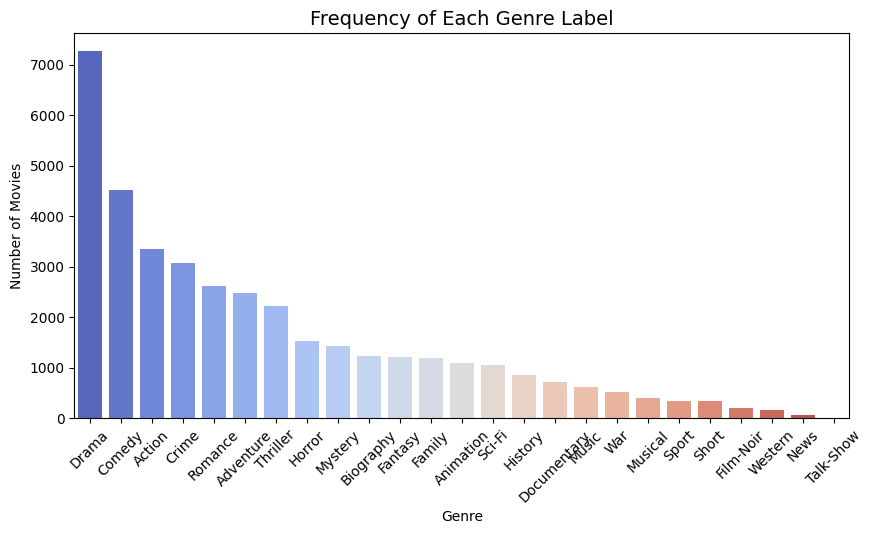

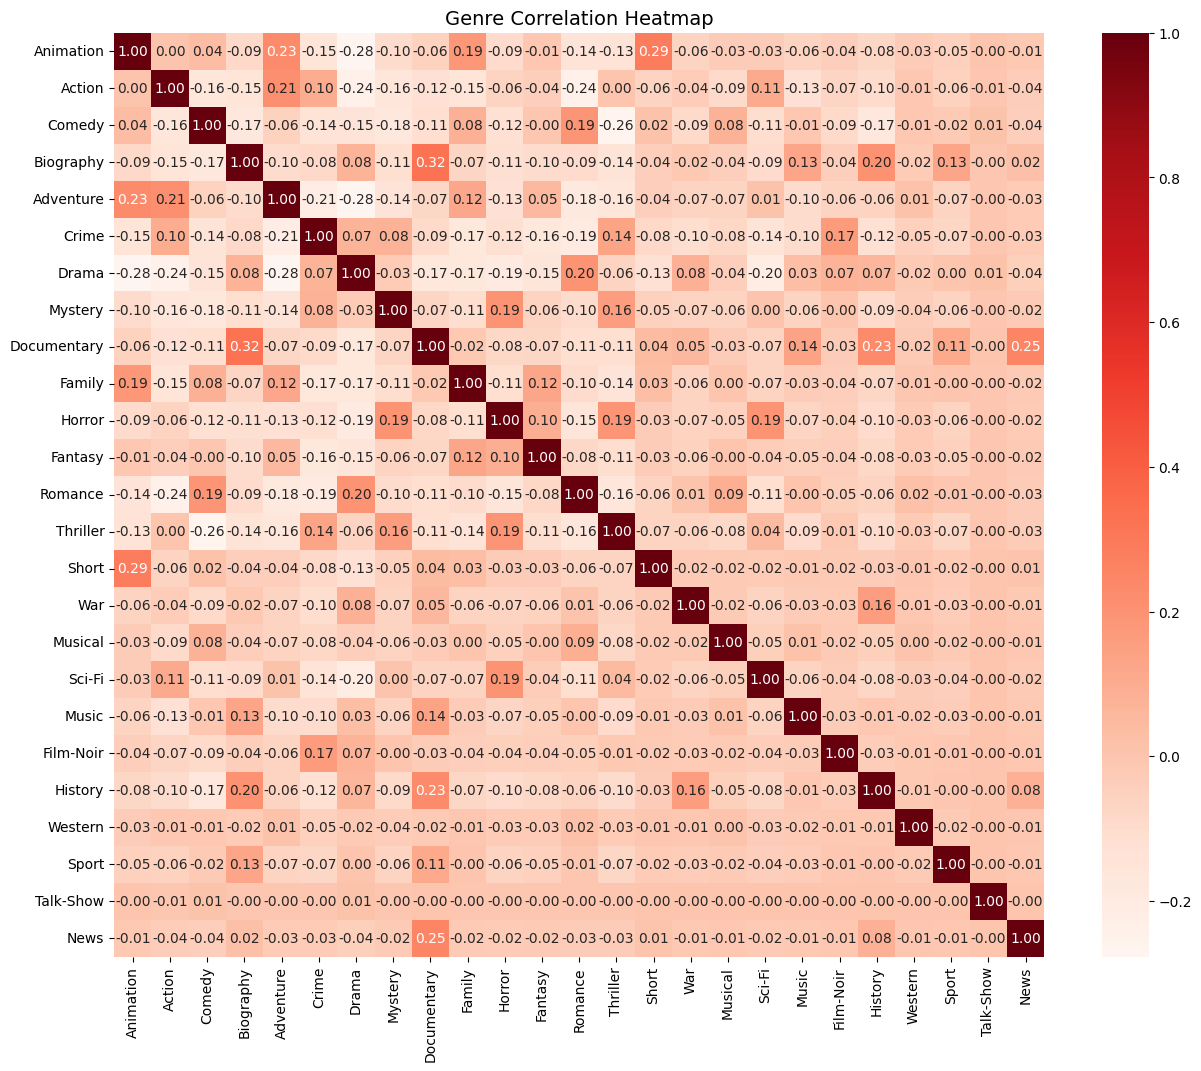

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Dataset shape:", df.shape)
print("\nUnique genres per column:")
for col in ['Genre_1', 'Genre_2', 'Genre_3']:
    print(f"{col}: {df[col].nunique()} unique values")

# Create Multilabel One-Hot Encoding

# Collect all unique genres across the 3 columns
all_genres = pd.unique(df[['Genre_1', 'Genre_2', 'Genre_3']].values.ravel('K'))
all_genres = [g for g in all_genres if pd.notnull(g)]

# Create binary columns for each genre
for genre in all_genres:
    df[genre] = df[['Genre_1', 'Genre_2', 'Genre_3']].apply(lambda x: int(genre in x.values), axis=1)

print("\nSample multilabel columns:\n", df.head())

# Genre Frequency (per label)
genre_counts = df[all_genres].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='coolwarm')
plt.title("Frequency of Each Genre Label", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Number of Movies")
plt.xlabel("Genre")
plt.show()

# Correlation Between Genres

plt.figure(figsize=(15,12)) # Increased figure size here
sns.heatmap(df[all_genres].corr(), annot=True, cmap="Reds", fmt=".2f")
plt.title("Genre Correlation Heatmap", fontsize=14)
plt.show()

# Label Cardinality and Density
num_movies = len(df)
num_labels = len(all_genres)
label_cardinality = df['num_genres'].mean()
label_density = label_cardinality / num_labels


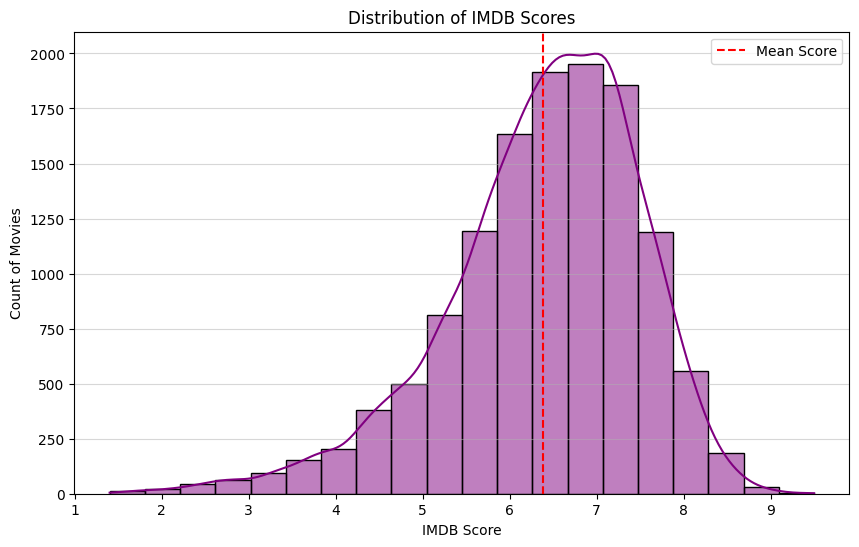

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
# Use a histogram with a kernel density estimate (KDE) to visualize the distribution
sns.histplot(df['IMDB Score'], bins=20, kde=True, color='purple')
plt.title('Distribution of IMDB Scores')
plt.xlabel('IMDB Score')
plt.ylabel('Count of Movies')
plt.axvline(df['IMDB Score'].mean(), color='red', linestyle='--', label='Mean Score')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

In [17]:
df = df.reset_index(drop=True)
df['Image_Index'] = df.index + 1
print(f"Index ranges from 1 to {df['Image_Index'].max()}")

Index ranges from 1 to 12797



--- Top 10 Primary Genres by Average IMDB Score ---
Genre_1
Documentary    7.362147
War            7.210000
Short          7.177228
Biography      6.928229
Film-Noir      6.900000
History        6.850000
Animation      6.791755
Crime          6.537578
Family         6.464286
Drama          6.436024
Name: IMDB Score, dtype: float64


/tmp/ipython-input-3388719866.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


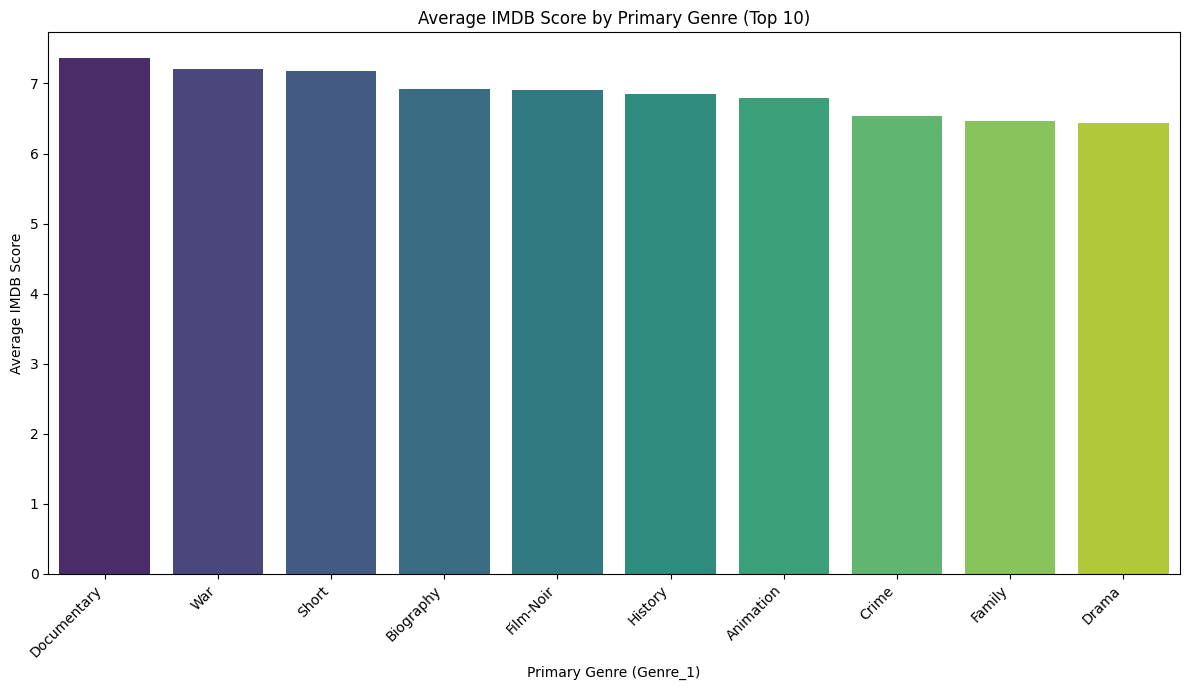

In [18]:
# Calculate the average IMDB Score for each primary genre
avg_score_by_genre1 = df.groupby('Genre_1')['IMDB Score'].mean().sort_values(ascending=False)

print("\n--- Top 10 Primary Genres by Average IMDB Score ---")
print(avg_score_by_genre1.head(10))

# Visualize the top genres
plt.figure(figsize=(12, 7))
sns.barplot(
    x=avg_score_by_genre1.head(10).index,
    y=avg_score_by_genre1.head(10).values,
    palette='viridis'
)
plt.title('Average IMDB Score by Primary Genre (Top 10)')
plt.xlabel('Primary Genre (Genre_1)')
plt.ylabel('Average IMDB Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

###**Total number of unique genres combinations**

In [19]:
# Combine all unique genres from the three positional columns
unique_genres_all = pd.concat([df['Genre_1'], df['Genre_2'], df['Genre_3']]).unique()

total_unique_count = len(unique_genres_all)

print(f"Total number of unique individual genres across all positions: {total_unique_count}")

Total number of unique individual genres across all positions: 25


###**Saving the dataset**

In [21]:
# Define the filename
output_filename = 'cleaned_three_genre_movie_list.csv'

# Save the DataFrame to a CSV file.
df.to_csv(output_filename, index=False)

print(f"Dataset saved successfully as: '{output_filename}'")

Dataset saved successfully as: 'cleaned_three_genre_movie_list.csv'


###**Download poster images**

In [22]:
!pip install tqdm
import pandas as pd
import requests
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Create the directory where images will be saved
IMAGE_DIR = 'movie_posters'
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

# --- Configuration ---
MAX_WORKERS = 32  # Number of concurrent threads
TIMEOUT_SECONDS = 10 # Timeout for each request

In [ ]:
def download_image(row):
    """
    Downloads the image from the URL in the 'Poster' column and saves it
    using the name from the 'Image_Index' column.
    Returns True if successful, False otherwise.
    """
    url = row['Poster']
    index = row['Image_Index']

    # save all images as .jpg for consistency
    filename = os.path.join(IMAGE_DIR, f"{index}.jpg")

    # Do not re-download if the file already exists
    if os.path.exists(filename):
        return True

    # Handle missing or non-string URLs
    if pd.isna(url) or not isinstance(url, str):
        return False

    try:
        # Use requests.get to download the entire content
        response = requests.get(url, stream=True, timeout=TIMEOUT_SECONDS)

        # Check for success status codes (2xx)
        if response.status_code == 200:
            with open(filename, 'wb') as file:
                # Write the content of the response to the file
                for chunk in response.iter_content(chunk_size=8192):
                    file.write(chunk)
            return True
        else:
            return False

    except requests.exceptions.RequestException:
        return False

In [ ]:
print(f"Starting concurrent image download for {len(df)} movies...")

# Get the list of rows as tuples for efficient concurrent processing
rows_to_download = df.to_dict('records')

download_results = []

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Use tqdm to wrap the executor.map for the progress bar
    download_results = list(tqdm(
        executor.map(download_image, rows_to_download),
        total=len(rows_to_download),
        desc="Downloading Posters"
    ))

# --- Final Check ---
success_count = sum(download_results)
failure_count = len(df) - success_count

print("\n--- Download Summary ---")
print(f"Total rows processed: {len(df)}")
print(f"Successfully downloaded: {success_count}")
print(f"Failed or skipped (already existing): {failure_count}")
print(f"Images saved to: {IMAGE_DIR}/")


Starting concurrent image download for 12795 movies...



--- Download Summary ---
Total rows processed: 12795
Successfully downloaded: 12776
Failed or skipped (already existing): 19
Images saved to: movie_posters/


In [ ]:
# Create a single ZIP archive named 'movie_posters.zip' from the directory
!zip -r movie_posters.zip movie_posters/


Streaming output truncated to the last 5000 lines.
  adding: movie_posters/11073.jpg (deflated 0%)
  adding: movie_posters/7325.jpg (deflated 0%)
  adding: movie_posters/8368.jpg (deflated 0%)
  adding: movie_posters/5863.jpg (deflated 0%)
  adding: movie_posters/817.jpg (stored 0%)
  adding: movie_posters/4413.jpg (stored 0%)
  adding: movie_posters/1023.jpg (stored 0%)
  adding: movie_posters/8383.jpg (stored 0%)
  adding: movie_posters/9622.jpg (deflated 0%)
  adding: movie_posters/10250.jpg (deflated 0%)
  adding: movie_posters/4834.jpg (stored 0%)
  adding: movie_posters/6422.jpg (stored 0%)
  adding: movie_posters/4205.jpg (stored 0%)
  adding: movie_posters/3403.jpg (deflated 0%)
  adding: movie_posters/2055.jpg (stored 0%)
  adding: movie_posters/118.jpg (stored 0%)
  adding: movie_posters/5178.jpg (stored 0%)
  adding: movie_posters/5469.jpg (stored 0%)
  adding: movie_posters/6276.jpg (stored 0%)
  adding: movie_posters/4002.jpg (stored 0%)
  adding: movie_posters/3721.jpg (s

In [ ]:
from google.colab import files

files.download('movie_posters.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>